In [1]:
import numpy as np
from sklearn.base import clone
import random 
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn

In [2]:
# import rangeland data 
tur = pd.read_csv("turkana_raw_w_soils.csv")
nar = pd.read_csv("narok_raw_w_soils.csv")

In [5]:
def find_ndvi_anomalies(df): 
    # pull ndvi columns 
    ndvi_cols = [col for col in df.columns if "F" in col and 'ppt' not in col]
    # calculate row wise quantile 
    Q1 = df[ndvi_cols].quantile(q=.25, axis = 1)
    Q4 = df[ndvi_cols].quantile(q=.75, axis = 1)
    
#     # make a boolean df to find values in each quantile 
    Q1bool = df[ndvi_cols].le(Q1)
    Q4bool = df[ndvi_cols].ge(Q4)

#     df['in_Q1'] = df.le(Q1).dot(df.columns + ',').str.rstrip(',').str.split(',')
#     df['in_Q4'] = df.ge(Q4).dot(df.columns + ',').str.rstrip(',').str.split(',')

In [6]:
find_ndvi_anomalies(nar)

['F20140125', 'F20140226', 'F20140517', 'F20140602', 'F20140618', 'F20140704', 'F20140720', 'F20140805', 'F20140821', 'F20141008', 'F20141024', 'F20141109', 'F20141125', 'F20141211', 'F20141227', 'F20150128', 'F20150213', 'F20150301', 'F20150317', 'F20150402', 'F20150504', 'F20150621', 'F20150707', 'F20150824', 'F20150909', 'F20151011', 'F20151128', 'F20151230', 'F20160216', 'F20160303', 'F20160319', 'F20160420', 'F20160522', 'F20160607', 'F20160709', 'F20160725', 'F20160826', 'F20160911', 'F20160927', 'F20161013', 'F20161029', 'F20161114', 'F20161130', 'F20161216', 'F20170117', 'F20170202', 'F20170218', 'F20170306', 'F20170322', 'F20170423', 'F20170525', 'F20170610', 'F20170829', 'F20170930', 'F20171016', 'F20171101', 'F20171117', 'F20171203', 'F20180205', 'F20180309', 'F20180325', 'F20180410', 'F20180512', 'F20180528', 'F20180731', 'F20180901', 'F20180917', 'F20181003', 'F20181104', 'F20181222', 'F20190107', 'F20190208', 'F20190312', 'F20190328', 'F20190413', 'F20190429', 'F20190718'

## Data Exploration

Text(0.04, 0.5, 'max Annual NDVI')

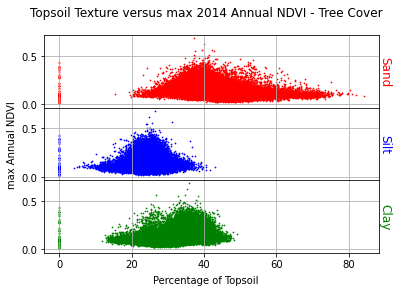

In [156]:
# plot all pixels annual mean2014 ndvi versus soil texture 
fig, (ax1,ax2,ax3) = plt.subplots(nrows=3, sharex=True, subplot_kw=dict(frameon=True)) # frameon=False removes frames

plt.subplots_adjust(hspace=.0)
ax1.grid()
ax2.grid()
ax3.grid()


ax1.scatter(lulc_df['sand_15_30']/10, lulc_df['max_ndvi2014'], s = .5, color = 'red', label = "Sand")
ax1.text(1.0, 0.5, "Sand",
        rotation=270, size=12, color = 'red', va='center', transform=ax1.transAxes)
# ax1.plot(df['sand_15_30']/10,sap(df['sand_15_30']/10),"b--")

ax2.scatter(lulc_df['silt_15_30']/10, lulc_df['max_ndvi2014'], s = .5, color = 'blue', label = "Silt")
ax2.text(1.0, 0.5, "Silt",
        rotation=270, size=12, color = 'blue', va='center', transform=ax2.transAxes)
# ax2.plot(df['silt_15_30']/10,sip(df['silt_15_30']/10),"b--")

ax3.scatter(lulc_df['clay_15_30']/10, lulc_df['max_ndvi2014'], s = .5, color = 'green', label = "Clay")
ax3.text(1.0, 0.5, "Clay",
        rotation=270, size=12, color = 'green', va='center', transform=ax3.transAxes)
# ax3.plot(df['clay_15_30']/10,clp(df['clay_15_30']/10),"b--")

plt.suptitle("Topsoil Texture versus max 2014 Annual NDVI - Tree Cover")
fig.text(0.5, 0.02, 'Percentage of Topsoil', ha='center')
fig.text(0.04, 0.5, 'max Annual NDVI', va='center', rotation='vertical')
# plt.savefig("C:\\Tara_Fall_2019\\Kenya_Drought\\FIGURES\\topsoil_v_std2014_ndvi_tree.jpg", dpi = 500);

## Bagging
Bootstrap aggregating, also called bagging, is a machine learning ensemble meta-algorithm designed to improve the stability and accuracy of machine learning algorithms used in statistical classification and regression. It also reduces variance and helps to avoid overfitting. Although it is usually applied to decision tree methods, it can be used with any type of method. Bagging is a special case of the model averaging approach.

Given a standard training set $D$ of size n, bagging generates $N$ new training sets $D_i$, roughly each of size n * ratio, by sampling from $D$ uniformly and with replacement. By sampling with replacement, some observations may be repeated in each $D_i$ The $N$ models are fitted using the above $N$ bootstraped samples and combined by averaging the output (for regression) or voting (for classification). 

-Source [Wiki](https://en.wikipedia.org/wiki/Bootstrap_aggregating)

In [29]:
def pull_reg_cols(df):
    # pull columns from narok dataframe
    all_columns = df.columns
    #ppt columns
    ppt_columns = [col for col in all_columns if 'ppt' in col]
    # soil columns     
    soil_columns = [col for col in all_columns if 'sand' in col or 'silt' in col or 'clay' in col or 'soc' in col or 'bdod' in col or 'cfvo' in col]
    #lulc
    lulc = ['cropland','grassland', 'shrub', 'trees']
    #target ndvi columns 
    target = [col for col in all_columns if 'ndvi' in col]

    to_keep = ppt_columns + soil_columns + lulc + target
    reg_df = df[to_keep]
    return (reg_df)

In [30]:
tur_reg = pull_reg_cols(tur)
nar_reg = pull_reg_cols(nar)

In [33]:
# train test split 
t_train, t_test = train_test_split(tur_reg, test_size = .2)
n_train, n_test = train_test_split(nar_reg, test_size = .2)

## Implementing Bagging [5-points]
***

We've given you a skeleton of the class `BaggingClassifier` below which will train a classifier based on the decision trees as implemented by sklearn. Your tasks are as follows, please approach step by step to understand the code flow:
* Implement `bootstrap` method which takes in two parameters (`X_train, y_train`) and returns a bootstrapped training set ($D_i$)
* Implement `fit` method which takes in two parameters (`X_train, y_train`) and trains `N` number of base models on different bootstrap samples. You should call `bootstrap` method to get bootstrapped training data for each of your base model
* Implement `voting` method which takes the predictions from learner trained on bootstrapped data points `y_hats` and returns final prediction as per majority rule. In case of ties, return either of the class randomly.
* Implement `predict` method which takes in multiple data points and returns final prediction for each one of those. Please use the `voting` method to reach consensus on final prediction.

In [112]:
from sklearn.tree import DecisionTreeRegressor

class BaggingClassifier:
    def __init__(self, ratio = 0.73, N = 20, base=DecisionTreeRegressor(max_depth=4)):
        """
        Create a new BaggingClassifier
        
        Args:
            base (BaseEstimator, optional): Sklearn implementation of decision tree
            ratio: ratio of number of data points in subsampled data to the actual training data
            N: number of base estimator in the ensemble
        
        Attributes:
            base (estimator): Sklearn implementation of decision tree
            N: Number of decision trees
            learners: List of models trained on bootstrapped data sample
        """ 
        
        assert ratio <= 1.0, "Cannot have ratio greater than one"
        self.base = base
        self.ratio = ratio
        self.N = N
        self.learners = []
        
#     def get_params(self, deep=True):
#         # suppose this estimator has parameters "alpha" and "recursive"
#         return {"base": self.base, "ratio": self.ratio, "N": self.N, "learners": self.learners}

#     def set_params(self, **parameters):
#         for parameter, value in parameters.items():
#             setattr(self, parameter, value)
#         return self
        
    def fit(self, X_train, y_train):
        """
        Train Bagging Ensemble Classifier on data
        
        Args:
            X_train (ndarray): [n_samples x n_features] ndarray of training data   
            y_train (ndarray): [n_samples] ndarray of data 
        """
        #TODO: Implement functionality to fit models on the bootstrapped samples
        # cloning sklearn models:
        # from sklearn.base import clone
        # h = clone(self.base)
        
        from sklearn.base import clone
                
        # clone the base model, train a model on a boostrapped training set
        # do this N times 
        learn_list = []
        for i in range(self.N):
            h = clone(self.base, safe = False)
            boot_x, boot_y = self.bootstrap(X_train, y_train)
            fitted_h = h.fit(boot_x, boot_y)
            learn_list.append(fitted_h)
            self.learners = learn_list
        
        
    def bootstrap(self, X_train, y_train):
        """
        Args:
            n (int): total size of the training data
            X_train (ndarray): [n_samples x n_features] ndarray of training data   
            y_train (ndarray): [n_samples] ndarray of data 
        """
        # Take in all training data, sample data uniformly with replacement 
        # number of samples in training data
        n = len(X_train)
        
        # uniformly sample indices with replacement, use these indices to pull training data and labels 
        # select n*ratio samples to use for bootstrapped training set
        indices = random.choices(range(n), k = int(n*self.ratio))
        
        # boostrapped X and Y 
        boot_x = [X_train[i] for i in indices]
        boot_y = [y_train[i] for i in indices]
        
        return (boot_x, boot_y)
        
    
    def predict(self, X):
        """
        BaggingClassifier prediction for data points in X
        
        Args:
            X (ndarray): [n_samples x n_features] ndarray of data 
            
        Returns:
            yhat (ndarray): [n_samples] ndarray of predicted labels {-1,1}
        """
        
        #TODO: Using the individual classifiers trained predict the final prediction using voting mechanism
        predictions = self.voting(X)
        return (predictions)
    
    def voting(self, y_hats):
        """
        Args:
            y_hats (ndarray): [N] ndarray of data
        Returns:
            y_final : int, final prediction of the 
        """
        #TODO: Implement majority voting scheme and incase of ties return random label
                
        # save list of arrays of predictions for each of the boostrapped models in the learners list
        learner_predictions = []
        
        # save the final voted predictions
        voted_predictions = []
        
        # iterate over each of the models, predict values for y_hats
        for i in range(self.N):
            model = self.learners[i]
            model_predictions = model.predict(y_hats)
            # append to list of arrays of predictions
            learner_predictions.append(model_predictions.copy())
        
        # make one array with all of the arrays in learner predictions 
        # each array of predictions for the y_hat points will be one row in the array
        # number of rows = N, one row for each model
        # number of columns = len(y_hats), one column for each data point being predicted
        stacked_predictions = np.vstack(learner_predictions)
        
        # transpose the above so that each row is the predictions for a given y_hat point
        # each column is a model 
        # each row is a point 
        per_point_preds = stacked_predictions.T
        
        # iterate all of the rows in per_point_preds, i.e. iterate over each point passed into the function
        for i in range(per_point_preds.shape[0]):
            # for each row/point, count the number of 1s and -1s and then decide what the 
            # voted prediction is for that point, append to voted_predictions
            ones = list(per_point_preds[i]).count(1)
            neg_ones = list(per_point_preds[i]).count(-1)
            if ones > neg_ones:
                voted_predictions.append(1)
            elif ones < neg_ones:
                voted_predictions.append(-1)
            else: 
                voted_predictions.append(random.choice([-1, 1]))
                
        # return the voted predictions 
        return(voted_predictions)
            

## BaggingClassifier for Handwritten Digit Recognition [5-points]
***

After you've successfully completed `BaggingClassifier` find the optimal values of `N` and `depth` using k-fold cross validation. You are allowed to use sklearn library to split your training data in folds. Keep the other hyperparameters unchanged. Use the data from `ThreesAndEights` class initialized variable `data`. 

Justify why those values are optimal

Report accuracy on the validation data using the optimal parameter values.

What is the most deciding hyperparameter and why?

Hint:  Vary `depth` up to 10, `N` up to 40. The number of decision trees `N` is generally a trade-off between 'improvement in accuracy' vs 'computation time'.

In [47]:
# split training data using sklearn library 
from sklearn.model_selection import KFold
K_fold = KFold(n_splits=5, shuffle = True)    

In [140]:
# set these
year = '2014'
lulc = 'grassland'
df = t_train 
target = 'max_ndvi2014'

all_cols = df.columns
year_cols = [col for col in all_cols if year in col]
x_cols = [col for col in year_cols if 'ndvi' not in col]
# soil columns     
soil_columns = [col for col in all_columns if 'sand' in col or 'silt' in col or 'clay' in col or 'soc' in col or 'bdod' in col or 'cfvo' in col]


X_cols = x_cols + soil_columns
#X_train subset by land use
lulc_subset = df[df[lulc] > 0]
# drop nan values 
good2go = lulc_subset[lulc_subset[target].notna()]

# then pull columns
X_train = good2go[X_cols].to_numpy()
y_train = good2go[target].to_numpy()

In [121]:
# to explore accuracy vs. N values 

# iterate over different N values, save the accuracy (averaged over all the folds) and the value for N 
accuracy_list = []
n_values = []

# start with N = 1, increment up to 40
N_val = 1
for i in range(40):
    # track the value of N
    n_values.append(N_val)
    
    # track the accuracy of all of the folds of training data for this value of N
    kf_accuracy = []
    
    # initialize BaggingClassifier 
    bag_class = BaggingClassifier(N = N_val)
    
    # complete kfold training of model with value of N
    for train_ind, test_ind in K_fold.split(X_train, y_train):
        # train BaggingClassifier on train data 
        bag_class.fit(X_train[train_ind], y_train[train_ind])
        # predict on test data 
        predictions = bag_class.predict(X_train[test_ind])
        # check accuracy on this k fold, save in list 
        accuracy = sklearn.metrics.r2_score(y_train[test_ind], predictions)
        
        # add accuracy of this fold to the list
        kf_accuracy.append(accuracy)
    
    # what is the average accuracy of the k fold classifiers trained with parameter N
    avg_acc_N = sum(kf_accuracy) / len(kf_accuracy)
    accuracy_list.append(avg_acc_N)
    
    # increment N before starting loop again 
    N_val += 1

In [122]:
accuracy_list[0]

-0.0001536423992882341

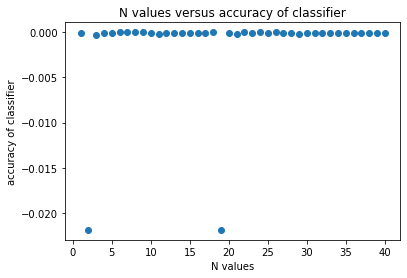

In [123]:
# now plot values from lists above 
plt.scatter(n_values, accuracy_list)
plt.xlabel('N values')
plt.ylabel('accuracy of classifier')
plt.title("N values versus accuracy of classifier")
plt.show()

### Optimal Values of N value 
The optimal value of N value is roughly 13. As we can see in the plot above of N values versus accuracy of classifier, the plateau of accuracy begins at about N = 13. Past this point, we do not see substantial increases in the accuracy of our classifier. By increasing N, we increase the number of base estimators in the classifier. The larger the value of N, the longer the run time. Thus since we do not see substantial increases in the accuracy of our classifier after N = 13, we should not make N larger or we greatly slow down the processing time. 

In [166]:
# to explore accuracy vs. depth  

# iterate over different depth values, save the accuracy (averaged over all the folds) and the value for depth 
accuracy_list = []
depth_values = []

# start with N = 1, increment up to 40
depth_val = 1
for i in range(30):
    # track the value of N
    depth_values.append(depth_val)
    
    # track the accuracy of all of the folds of training data for this value of N
    kf_accuracy = []
    
    # initialize BaggingClassifier 
    bag_class = BaggingClassifier(base=DecisionTreeClassifier(max_depth=depth_val))
    
    # complete kfold training of model with value of N
    for train_ind, test_ind in K_fold.split(data.X_train, data.y_train):
        # train BaggingClassifier on train data 
        bag_class.fit(data.X_train[train_ind], data.y_train[train_ind])
        
        # predict on test data 
        predictions = bag_class.predict(data.X_train[test_ind])
        
        # check accuracy on this k fold, save in list 
        accuracy_check = list(map(lambda x, y: x == y, predictions, data.y_train[test_ind]))
        correct = accuracy_check.count(True)
        incorrect = accuracy_check.count(False)
        accuracy = correct / (correct + incorrect)
        
        # add accuracy of this fold to the list
        kf_accuracy.append(accuracy)
    
    # what is the average accuracy of the k fold classifiers trained with parameter N
    avg_acc_d = sum(kf_accuracy) / len(kf_accuracy)
    accuracy_list.append(avg_acc_d)
    
    # increment N before starting loop again 
    depth_val += 1

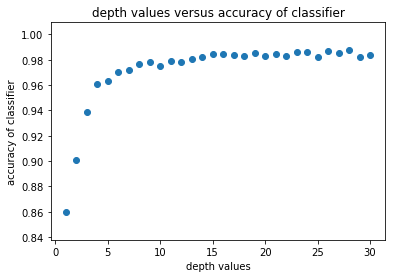

In [167]:
# now plot values from lists above 
plt.scatter(depth_values, accuracy_list)
plt.xlabel('depth values')
plt.ylabel('accuracy of classifier')
plt.title("depth values versus accuracy of classifier")
plt.show()

# QUESTION: IS THE ACCURACY SUPPOSED TO TIP OFF SOMEWHERE WHEN IT STARTS OVERFITTING? 

### Optimal Values of and Depth 
The optimal value of depth is roughly 15. As we can see in the plot above of depth versus accuracy of classifier, the plateau of accuracy begins at about depth = 15. Past this point, we do not see substantial increases in the accuracy of our classifier. By increasing depth, we increase the number of nodes in our base decision tree. By increasing the number of nodes in the base decision tree, we have a tighter fit to our data and hence a higher accuracy. The larger the value of depth, the longer the run time. Since we do not see substantial increases in the accuracy of our classifier after depth = 15, we should not make depth larger or we greatly slow down the processing time. Also, if we continue to increase depth, we may begin to see the accuracy decrease as we are likely overfitting our data. 

In [274]:
# report accuracy on validation data using optimal parameter values from above
# initialize BaggingClassifier 
bag_class = BaggingClassifier(base=DecisionTreeClassifier(max_depth=depth_val))
    

# train BaggingClassifier on validation data 
bag_class.fit(data.X_train, data.y_train)

# predict on test data 
predictions = bag_class.predict(data.X_valid)

# check accuracy on this k fold, save in list 
accuracy_check = list(map(lambda x, y: x == y, predictions, data.y_valid))
correct = accuracy_check.count(True)
incorrect = accuracy_check.count(False)
accuracy = correct / (correct + incorrect)

# Accuracy of classifier on validation data
print ("Accuracy of classifier on validation data: ", accuracy)

### Which is the most deciding parameter and why?
The most deciding hyperparameter is the depth parameter. While changing the number of ensembles does improve the accuracy of the classifier, it does not do so by a large margin. Averaging many classifiers which have roughly the same accuracy will not yield substantially higher accuracies, it will buffer any outlier ensemble classifiers which did a poor job at classifying but it will not drastically change the accuracy of the overall classifier. Depth, however, has a substantial effect on the accuracy of the classifier. By changing the number of nodes in the base decision tree, the fit to our data gets tighter which makes the accuracy improve. Furthermore, if we continued to increase the depth, we could overfit the data. The depth parameter thus plays a larger role in the accuracy of our classifier. 

# Random Decision Tree [10-points]

In this assignment you are going to implement a random decision tree using random vector method as discussed in the lecture.

Best split: One that achieves maximum reduction in gini index across multiple candidate splits. (decided by `candidate_splits` attribute of the class `RandomDecisionTree`)

Use `TreeNode` class as node abstraction to build the tree

You are allowed to add new attributes in the `TreeNode` and `RandomDecisionTree` class - if that helps.

Your tasks are as follows:
* Implement `gini_index` method which takes in class labels as parameter and returns the gini impurity as measure of uncertainty

* Implement `majority` method which picks the most frequent class label. In case of tie return any random class label

* Implement `find_best_split` method which finds the random vector/hyperplane which causes most reduction in the gini index. 

* Implement `build_tree` method which uses `find_best_split` method to get the best random split vector for current set of training points. This vector partitions the training points into two sets, and you should call `build_tree` method on two partitioned sets and build left subtree and right subtree. Use `TreeNode` as abstraction for a node.

> The method calls itself recursively to the generate left and right subtree till the point either `max_depth` is reached or no good random split is found.  When either of two cases is encountered, you should make that node as leaf and identify the label for that leaf to be the most frequent class (use `majority` method). Go through lecture slides for better understanding

* Implement `predict` method which takes in multiple data points and returns final prediction for each one of those using the tree built. (`root` attribute of the class)

In [5]:
class TreeNode:
    def __init__(self):
        self.left = None
        self.right = None
        self.isLeaf = False
        self.label = None
        self.split_vector = None

    def getLabel(self):
        if not self.isLeaf:
            raise Exception("Should not do getLabel on a non-leaf node")
        return self.label
    
class RandomDecisionTree:
            
    def __init__(self, candidate_splits = 100, depth = 10):
        """
        Args:
            candidate_splits (int) : number of random decision splits to test
            depth (int) : maximum depth of the random decision tree
        """
        self.candidate_splits = candidate_splits
        self.depth = depth
        self.root = None
    
    def fit(self, X_train, y_train):
        """
        Args:
            X_train (ndarray): [n_samples x n_features] ndarray of training data   
            y_train (ndarray): [n_samples] ndarray of data
            
        """
        self.root = self.build_tree(X_train[:], y_train[:], 0)
        return self
        
    def build_tree(self, X_train, y_train, height):
        """
        Args:
            X_train (ndarray): [n_samples x n_features] ndarray of training data   
            y_train (ndarray): [n_samples] ndarray of data
            
       Return:
            split_vector: random vector which gives most reduction in uncertainty
            feature_indices: indices of the random sub-features used
            lindices: indices of training example which should be in left subtree
            rindices: indices of training example which should be in right subtree
            
        """ 
        # build until you reach the maximum height or until no good random split is found
        # how to test for no good split is found?
        node = TreeNode()
        label = None 
        
        # check if max height has been reached
        if (height == self.depth):
            # then stop!! 
            label = self.majority(y_train)
            node.isLeaf = True
            node.label = label
            return (node)
            

        # split data 
        split_vector = self.find_best_split(X_train, y_train)

        # save split vector
        node.split_vector = split_vector
        

        # vectors to check if no random vector was found 
        none_found = np.zeros((784,),float)
        comparison = (split_vector == none_found)
            
        # split_vector will be all zeros if it no random vector is found to provide a benefit in gini index
        # if a random vector is not found, STOP
        if comparison.all():
            # then you are a leaf! 
            label = self.majority(y_train)
            node.isLeaf = True
            node.label = label
            return (node)
        
        # If neither of the stop conditions was met, keep building! 
        
        # initialize left and right indices 
        lindices = []
        rindices = []

        # split into left and right indices groups by taking the dot product of split vector and points
        for idx in range(len(X_train)): 
            if np.dot(split_vector, X_train[idx]) > 0: 
                lindices.append(idx)
            else: 
                rindices.append(idx)

        # update the height before recursing
        update_height = height + 1
        
        # then pass left and right indices to build_tree again, save left and right subtrees (if left and right subtrees aren't empty)
        if len(lindices)!= 0:
            node.left = self.build_tree([X_train[i] for i in lindices], [y_train[i] for i in lindices], update_height)
            
        if len(rindices) != 0:
            node.right = self.build_tree([X_train[i] for i in rindices], [y_train[i] for i in rindices], update_height)

        
        return node
    
    def find_best_split(self, X_train, y_train):
        """
        Args:
            X_train (ndarray): [n_samples x n_features] ndarray of training data   
            y_train (ndarray): [n_samples] ndarray of data
            
        """
        # number of random vectors to test
        n = self.candidate_splits
        #initialize split_vector
        split_vector = np.zeros((784,),float)

        base_gini = self.gini_index(y_train)
        #initialize max_benefit
        max_benefit = 0
        for i in range(n):
            # create a random vector, same shape as X data points 
            random_vector = np.random.uniform(low = -1, high = 1, size = (784,))

            # split the dataset into left and right groups based on dot product with random_vector
            # initialize lists for left and right of the value
            left = []
            right = []
            for idx in range(len(X_train)): 
                if np.dot(random_vector, X_train[idx]) > 0: 
                    left.append(y_train[idx])
                else: 
                    right.append(y_train[idx])
                    
            # case for if len(X_train) = 0, i.e. empty set passed into method 
            if len(X_train) == 0:
                return split_vector
            
            # to calculate benefit of split
            left_gini = self.gini_index(left) 
            prob_left = len(left)/len(X_train)
            right_gini = self.gini_index(right)
            prob_right = len(right)/len(X_train)

            # benefit of split per lecture 4
            benefit_of_split = (base_gini - (prob_left*left_gini + prob_right*right_gini))*len(X_train)

            # if the benefit of split is larger than current max_benefit, replace split_vector with the random vector 
            if benefit_of_split > max_benefit: 
                max_benefit = benefit_of_split
                split_vector = random_vector
        
        return split_vector
            
        
    def gini_index(self, y):
        """
        Args:
            y (ndarray): [n_samples] ndarray of data
        """
        # Do we have to write this ourselves or can we use other packages to determine Gini index?
        
        # take in class labels 
        unique, counts = np.unique(y, return_counts = True)
        
        # calculate number of points in y
        total_labels = len(y)
        
        #initialize gini index
        gini = 0
        
        # case for empty list of y values passed 
        if (total_labels == 0):
            return (gini)
        
        # iterate over all labels 
        for i in range(len(unique)): 
            gini += ((counts[i]/total_labels)*(1-(counts[i]/total_labels)))
            
        return (gini)
    
    def majority(self, y):
        """
        Return the major class in ndarray y
        """
        # take in class labels and their counts
        unique, counts = np.unique(y, return_counts = True)
        
        # find the indices in counts where the maximum occurs
        max_index = np.where(counts == max(counts))
        
        # pull values out of unique by using max_index
        max_values = unique[max_index]
        
        if len(y) == 0: 
            return (None)
        
        # if there is only one maximum 
        if (len(max_values) == 1):
            max_label = max_values[0]
        else: 
            max_label = random.choice(unique)
            
        return (max_label)
    
    def predict(self, X):
        """
        BaggingClassifier prediction for new data points in X
        
        Args:
            X (ndarray): [n_samples x n_features] ndarray of data 
            
        Returns:
            yhat (ndarray): [n_samples] ndarray of predicted labels {-1,1}
        """
        #initialize array of predicted labels 
        yhat = []
        # get predictions for all of the X values passed into the method
        for row in X:
            # initialize a  a label 
            label = None
            # test left or right of root
            current_node = self.root
            current_vec = current_node.split_vector
            # initialize hit_leaf indicator
            hit_leaf = current_node.isLeaf
            
            # run until you hit a leaf node
            while hit_leaf == False:
                if np.dot(current_vec, row) > 0: 
                    # go to the left
                    current_node = current_node.left
                    current_vec = current_node.split_vector
                    # are you a leaf?
                    hit_leaf = current_node.isLeaf
                    if (hit_leaf == True): 
                        label = current_node.label
                else: 
                    # go to the right
                    current_node = current_node.right
                    current_vec = current_node.split_vector
                    # are you a leaf?
                    hit_leaf = current_node.isLeaf
                    if (hit_leaf == True): 
                        label = current_node.label
            yhat.append(label)
        
        return (yhat)
            

## RandomDecisionTree for Handwritten Digit Recognition

a) After you've successfully completed `RandomDecisionTree`, and train using the default values in the constructor and report accuracy on the `valid_set`. Use the data from `ThreesAndEights` class initialized variable `data` 

b) Vary the `depth` up to 20 and comment on the trend that you observe in the accuracy scores of the `valid_set`. Base your comments on the concepts taught in the class. Keep the other hyperparameters unchanged.

In [6]:
# Train decision tree 
rdt = RandomDecisionTree()
rdt.fit(data.X_train, data.y_train)

In [30]:
# Report accuracy on validation set 
y_predicted = rdt.predict(data.X_valid)

# check accuracy on this k fold, save in list 
accuracy_check = list(map(lambda x, y: x == y, y_predicted, data.y_valid))
correct = accuracy_check.count(True)
incorrect = accuracy_check.count(False)
accuracy = correct / (correct + incorrect)

print ("Accuracy of Random Decision Tree on validation set: ", accuracy)

Accuracy of Random Decision Tree on validation set:  0.8867091711623345


In [ ]:
# Depth vs Accuracy 
# to explore accuracy vs. depth  

# iterate over different depth values, save the accuracy (averaged over all the folds) and the value for depth 
accuracy_list = []
depth_values = []

# start with N = 1, increment up to 40
depth_val = 1
for i in range(20):
    # track the value of N
    depth_values.append(depth_val)
    
    # Train decision tree 
    rdt = RandomDecisionTree(depth = depth_val)
    rdt.fit(data.X_train, data.y_train)

    # Report accuracy on validation set 
    y_predicted = rdt.predict(data.X_valid)

    # check accuracy on this k fold, save in list 
    accuracy_check = list(map(lambda x, y: x == y, y_predicted, data.y_valid))
    correct = accuracy_check.count(True)
    incorrect = accuracy_check.count(False)
    accuracy = correct / (correct + incorrect)
    
    #append accuracy 
    accuracy_list.append(accuracy)
    
    # increment N before starting loop again 
    depth_val += 1

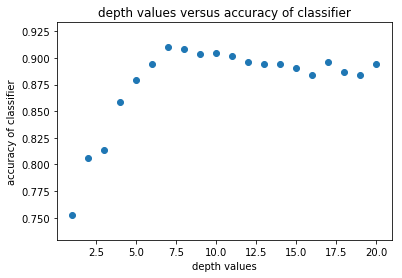

In [361]:
# now plot values from lists above 
plt.scatter(depth_values, accuracy_list)
plt.xlabel('depth values')
plt.ylabel('accuracy of classifier')
plt.title("depth values versus accuracy of classifier")
plt.show()

### Discussion of Depth vs Accuracy 
As we see in the above plot, as we increase the depth of the random decision tree, the accuracy improves. As was discussed in class, past a certain depth we begin to see overfitting as our accuracy decreases after it reaches a peak. A tree which is too deep will model the chance structure of the training data rather than capturing the actual structure of the data. In the above plot, the ideal depth is depth = 7. 

# Random Forest [5-points]
Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks, that operate by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees. Random decision forests correct for decision trees' habit of overfitting to their training set.

Random forest trains random decision trees on bootstrapped training points. Thus, you can try implementation of methods (`bootstrap`, `predict`) from `BaggingClassifier` class directly. Only difference being, you have to use the `RandomDecisionTree` as base which you implemented previously instead of sklearn's implementation of `DecisionTreeClassifier`). Implement the `fit` method in the class below accordingly.

In [6]:
#inheriting BaggingClassifier, you do not need to pass in a BaggingClassifier object! 
class RandomForest(BaggingClassifier):
    def __init__(self, ratio = 0.63, N = 20, max_depth = 10, candidate_splits = 500):
        self.ratio = ratio
        self.N = N  
        self.learners = []
        self.candidate_splits = candidate_splits
        self.max_depth = max_depth
        
    def fit(self, X_train, y_train):
        """
        Train Bagging Ensemble Classifier on data
        
        Args:
            X_train (ndarray): [n_samples x n_features] ndarray of training data   
            y_train (ndarray): [n_samples] ndarray of data 
        """
        # instantiate a bagging classifier
        classifier = BaggingClassifier(self.ratio, self.N, base=RandomDecisionTree(candidate_splits = self.candidate_splits, depth = self.max_depth))
        
        # fit bagging classifier 
        classifier.fit(X_train, y_train)
        
        self.learners = classifier.learners

## RandomForest for Handwritten Digit Recognition [5-points]
***

After you've successfully completed `RandomForest` find the optimal values of `N` and `max_depth` ,  using k-fold cross validation. Fix the values of the other hyperparameters to the given defaults. Feel free to use sklearn library to split your training data. Use the data from `ThreesAndEights` class intialized variable `data`. 

Justify why those values are optimal. 

Report best accuracy on the testing data using the optimal `N`.

Hint: Vary `N` up to 25 and set `max_depth` up to 10. Plan ahead as it might take some time.

### Exploration of parameter values - 

This process ran for 24 hours and was still not done running, thus since it is close to the deadline I have interrupted the process and will explore the N values and depth using a small sample of the training set and less iterations for N and max_depth

In [7]:
# explore N up to 25

# split training data using sklearn library 
from sklearn.model_selection import KFold
K_fold = KFold(n_splits=4, shuffle = True) 
import random

# to explore accuracy vs. N values 

# iterate over different N values, save the accuracy (averaged over all the folds) and the value for N 
n_accuracy_list = []
n_values = []

# start with N = 1, increment up to 25
N_val = 1
for i in range(12):
    # track the value of N
    n_values.append(N_val)
    
    # track the accuracy of all of the folds of training data for this value of N
    kf_accuracy = []
    
    # initialize BaggingClassifier 
    rf = RandomForest(N = N_val)
    
    # random sample of 100 training points to illustrate the optimization of N and max_depth
    random_ind = random.sample(range(len(data.X_train)), 100)
    
    # complete kfold training of model with value of N
    for train_ind, test_ind in K_fold.split(data.X_train[random_ind], data.y_train[random_ind]):
        # train BaggingClassifier on train data 
        rf.fit(data.X_train[train_ind], data.y_train[train_ind])
        
        # predict on test data 
        predictions = rf.predict(data.X_train[test_ind])
        
        # check accuracy on this k fold, save in list 
        accuracy_check = list(map(lambda x, y: x == y, predictions, data.y_train[test_ind]))
        correct = accuracy_check.count(True)
        incorrect = accuracy_check.count(False)
        accuracy = correct / (correct + incorrect)
        
        # add accuracy of this fold to the list
        kf_accuracy.append(accuracy)
    
    # what is the average accuracy of the k fold classifiers trained with parameter N
    avg_acc_N = sum(kf_accuracy) / len(kf_accuracy)
    n_accuracy_list.append(avg_acc_N)
    
    # increment N before starting loop again 
    print ("N_val completed: ", N_val)    
    N_val += 2

N_val completed:  1
N_val completed:  3
N_val completed:  5
N_val completed:  7
N_val completed:  9
N_val completed:  11
N_val completed:  13
N_val completed:  15
N_val completed:  17
N_val completed:  19
N_val completed:  21
N_val completed:  23


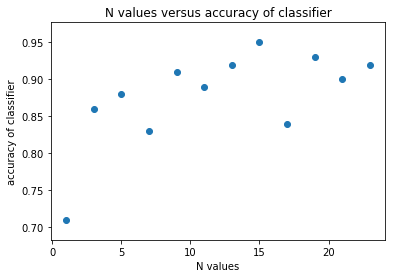

In [8]:
# now plot values from N lists above 
plt.scatter(n_values, n_accuracy_list)
plt.xlabel('N values')
plt.ylabel('accuracy of classifier')
plt.title("N values versus accuracy of classifier")
plt.show()

In [9]:
# explore max_depth up to 10

# iterate over different max_depth values, save the accuracy (averaged over all the folds) and the value for max_depth 
d_accuracy_list = []
depth_values = []

# start with N = 1, increment up to 25
depth = 1
for i in range(5):
    # track the value of N
    depth_values.append(depth)
    
    # track the accuracy of all of the folds of training data for this value of N
    kf_accuracy = []
    
    # initialize BaggingClassifier 
    rf = RandomForest(max_depth = depth)
    
    # random sample of 100 training points to illustrate the optimization of N and max_depth
    random_ind = random.sample(range(len(data.X_train)), 100)
    
    # complete kfold training of model with value of N
    for train_ind, test_ind in K_fold.split(data.X_train[random_ind], data.y_train[random_ind]):
        # train BaggingClassifier on train data 
        rf.fit(data.X_train[train_ind], data.y_train[train_ind])
        
        # predict on test data 
        predictions = rf.predict(data.X_train[test_ind])
        
        # check accuracy on this k fold, save in list 
        accuracy_check = list(map(lambda x, y: x == y, predictions, data.y_train[test_ind]))
        correct = accuracy_check.count(True)
        incorrect = accuracy_check.count(False)
        accuracy = correct / (correct + incorrect)
        
        # add accuracy of this fold to the list
        kf_accuracy.append(accuracy)
    
    # what is the average accuracy of the k fold classifiers trained with parameter N
    avg_acc_D = sum(kf_accuracy) / len(kf_accuracy)
    d_accuracy_list.append(avg_acc_D)
    
    # increment N before starting loop again 
    print ("max_depth completed: ", depth) 
    depth += 2

max_depth completed:  1
max_depth completed:  3
max_depth completed:  5
max_depth completed:  7
max_depth completed:  9


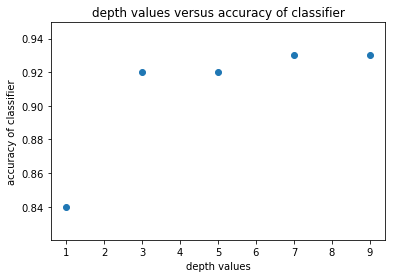

In [10]:
# now plot values from depth lists above 
plt.scatter(depth_values, d_accuracy_list)
plt.xlabel('depth values')
plt.ylabel('accuracy of classifier')
plt.title("depth values versus accuracy of classifier")
plt.show()

### Optimal Values of N and max_depth 
The optimal value of N is somewhere between 12 and 15. The optimal value of depth is somewhere between 7 and 9. If I had more time to run code, I would have done a higher grannularity exploration, but for a small set of training points and a handful of N and depth values, I find that the accuracy improves as I increase N and depth and then plateaus signaling a lack of sufficient increase in accuracy to warrant the higher computation time. Since RandomForest is so computationally expensive, choosing N and depth values which are as low as possible is ideal. 

In [11]:
# Testing on test data with optimal parameters 
rf = RandomForest(N = 15, max_depth = 7)
rf.fit(data.X_train, data.y_train)

In [12]:
# make predictions on validation data
y_predicted = rf.predict(data.X_valid)

In [13]:
# check accuracy on this k fold, save in list 
accuracy_check = list(map(lambda x, y: x == y, y_predicted, data.y_valid))
correct = accuracy_check.count(True)
incorrect = accuracy_check.count(False)
accuracy = correct / (correct + incorrect)

print ("Accuracy on testing data: ", accuracy)

Accuracy on testing data:  0.9705738106915155
